The variable and column names largely follow the conventions established in the paper. The implementation of the Random Fourier Features (RFF) and the model can be found in [rff.py](rff.py) and [backtest.py](backtest.py).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import itertools

import dataset
from rff import RFF
from backtest import Backtest

from joblib import Parallel, delayed

In [2]:
COLUMNS = dataset.COLUMNS
nber = dataset.load_nber()
data, returns = dataset.load_data()

# Standarize data

From the paper:

> We volatility standardize returns and predictors using backward-looking standard deviations that preserve the out-of-sample nature of our forecasts. 

> Returns are standardized by their trailing 12-month return standard deviation (to capture their comparatively fastmoving conditional volatility), while predictors are standardized using an expanding window historical standard deviation (given the much higher persistence of most predictors). 

> We require 36 months of data to ensure that we have enough stability in our initial predictor standardization, so the final sample that we bring to our analysis begins in 1930. We perform this standardization to align the empirical analysis with our homoskedastic theoretical setting, **but our results are insensitive to this step (none of our findings are sensitive to variations in how standardizations are implemented)**

In [3]:
for col in COLUMNS:
    data[col] = (data[col] - data[col].expanding(36).mean())/data[col].expanding(36).std()
# Standarize return by the std of the last 12 values
returns_std = returns.rolling(12).std()
returns = returns / returns_std

data = data[36:]
returns = returns[36:]

# Simulation

### Parameters

In [4]:
T = 12 # Number of Observations
gammas = [0.25, 0.5, 1, 2, 4] # Used in the creation of RFF with omega ~ iidN(0, gamma*I)
z_values = list(np.logspace(-3, 6, 10)) # Ridge Shrinkage

# Complexity of the model: c = #(Observations)/#(Features)
# The values will be plotted on a log-scale.
C_values = (
    list(np.logspace(-1, 0, 25, base=10)) +
    list(np.logspace(0, 1, 25, base=10)) +
    list(np.logspace(1, 2, 25, base=10)) +
    list(np.logspace(2, 3, 25, base=10))
)
# Number of Features
P_values = [c*T for c in C_values]
# RFF does always create 2 features (sin & cos) => P is a multiple of 2.
# Get a unique list of multiple of 2s
P_values = list({2*round(P/2) for P in P_values})
P_values.sort()

# Define the number of iterations to perform in order to reduce variance
# due to the randomness of RFF features
iterations = list(np.arange(1, 501))

### Backtest

In [5]:
# Runtime for 12 virtual cores
# 200 iterations: 1885min
# 500 iterations: 4620min
if "metrics.parquet"  in os.listdir("data"):
    metrics = pd.read_parquet(f"data/metrics.parquet")
else:
    # Parallelize the simulation using joblib's Parallel function
    def simulation(data, returns, gamma, P, z, iteration):
        c = P/T
        rff_data = RFF(n=int(P/2), gamma=gamma).features(data, seed=iteration)
        # 1-step ahead prediction
        sim = Backtest(z=z, T=T).predict(X=rff_data, y=returns.shift(-1))
        performance = sim.performance()
        performance.update({"gamma": gamma, "P": P, "z": z, "c": c, "T": T, "iteration": iteration})
        return performance
    
    metrics = Parallel(n_jobs=-1)(
        delayed(simulation)(data, returns, gamma, P, z, iteration=seed) 
        for gamma, P, z, seed in itertools.product(gammas, P_values, z_values, iterations)
    )
    metrics = pd.DataFrame(metrics)
    metrics.to_parquet((f"data/metrics.parquet"))

metrics_mean = metrics.groupby(["gamma", "P", "z", "c", "T"]).mean().reset_index().drop("iteration", axis=1)
metrics_mean["log10(z)"] = np.log10(metrics_mean["z"])

### Baseline
Do the same 1-step ahead prediction with the dataset instead of RFF and pick the best metric for each possible z.

In [6]:
baseline = []

# Compute baseline performance for each z
for z in z_values:
    backtest = Backtest(z=z, T=T).predict(X=data[COLUMNS], y=returns.shift(-1))
    performance = backtest.performance()
    performance.update({"z": z})
    baseline.append(performance)

baseline = pd.DataFrame(baseline)
baseline_dict = baseline[["Expected Return", "SR", "IR", "Alpha", "Precision", "Recall", "Accuracy"]].max().to_dict()

print("Baseline Results:")
for k,v in baseline_dict.items():
    print(f"\t - {k}: {v}")

Baseline Results:
	 - Expected Return: 0.755516767501831
	 - SR: 0.42364819114697444
	 - IR: 0.22262066614304674
	 - Alpha: 0.03032144531607628
	 - Precision: 0.6169934640522876
	 - Recall: 0.7303543913713405
	 - Accuracy: 0.5695970695970696


# Result

## Paper: 

Note: **Footnote [25]**
> More specifically, the first column reports summary statistics for the market return with rolling 12-month volatility standardization. Thus, the buy-and-hold version of this asset is itself a basic timing strategy, where timing is inversely proportional to rolling volatility. We do this simply because the standardized market is the target in our forecasting analysis. Our results across the board are generally insensitive to, and our conclusions entirely unaffected by, whether we work with the raw or volatility standardized market return. As noted earlier, we prefer to use the volatility standardized market because it aligns more directly with our theoretical framework.

**Expected result:**

|    | High Complexity Machine |
|----|-------------------------|
|  z |                    1000 |
|  c |                    1000 |
| R2 |                      8% |
| SR | 0.46                    |
| IR | 0.31                    |

Page 48 reports R2 as "per month". The Sharpe Ratio value seems to be more fitting if you annualize the data.

In [7]:
result = metrics_mean[(metrics_mean.gamma==2) & (metrics_mean.z==1000) & (metrics_mean.c == 1000)][["Expected Return", "R2", "SR", "IR"]].max().to_dict()

print("Our Results:")
for k,v in result.items():
    print(f"\t - {k}: {v}")

Our Results:
	 - Expected Return: 0.14155755420774221
	 - R2: -0.018180212204414466
	 - SR: 0.4180544281831089
	 - IR: 0.1977815109971277


# Plots
Here we present several visualizations to analyze our metrics. We use a logarithmic scale on the left to better represent the results for each `c` in the range `[0, 1000]`. The right-hand side provides plots similar to those in the original paper, but with a broken x-axis for `c` in the ranges `[0, 50]` and `[950, 1000]`.

We also provide plots for specific metrics, such as the Sharpe Ratio, for particular ranges of `log10(z)`. This allows us to better visualize the differences for each value of `log10(z)`. Additionally, we show plots for various `gamma` values to validate footnote [24]:  
> We set γ = 2. Our results are generally insensitive to γ, as discussed in the robustness section below.

The critical point at `c=1` (meaning the number of observations equals the number of features resulting in) is indicated by a vertical grey line. **The baseline value of a simple Ridge regression without Random Fourier Features is marked by a horizontal black line, aiding in the comparison and identification of improvements.**


--------------------------

Overall, our plots show a trend consistent with the original paper, although there are differences in specific values. These discrepancies may stem from different specific implementation choices (e.g., beta adjustment?).


The metrics are displayed blow. Compared to page 39:
- beta_norm_mean: comparable
- Expected Return: 10x higher. Figure 7 of the paper indicates that it is the "Market Timing Performance", which is what I used (annualized)
- Volatility: our results are approximately twice as high
- R2: comparable

The following metrics are extremely similar to those shown in Figure 8 of the paper (p41)
- Sharpe Ratio
- Information Ratio
- Alpha

**All values are below the regression benchmark** for `gamma==2`. 

gamma == 0.5


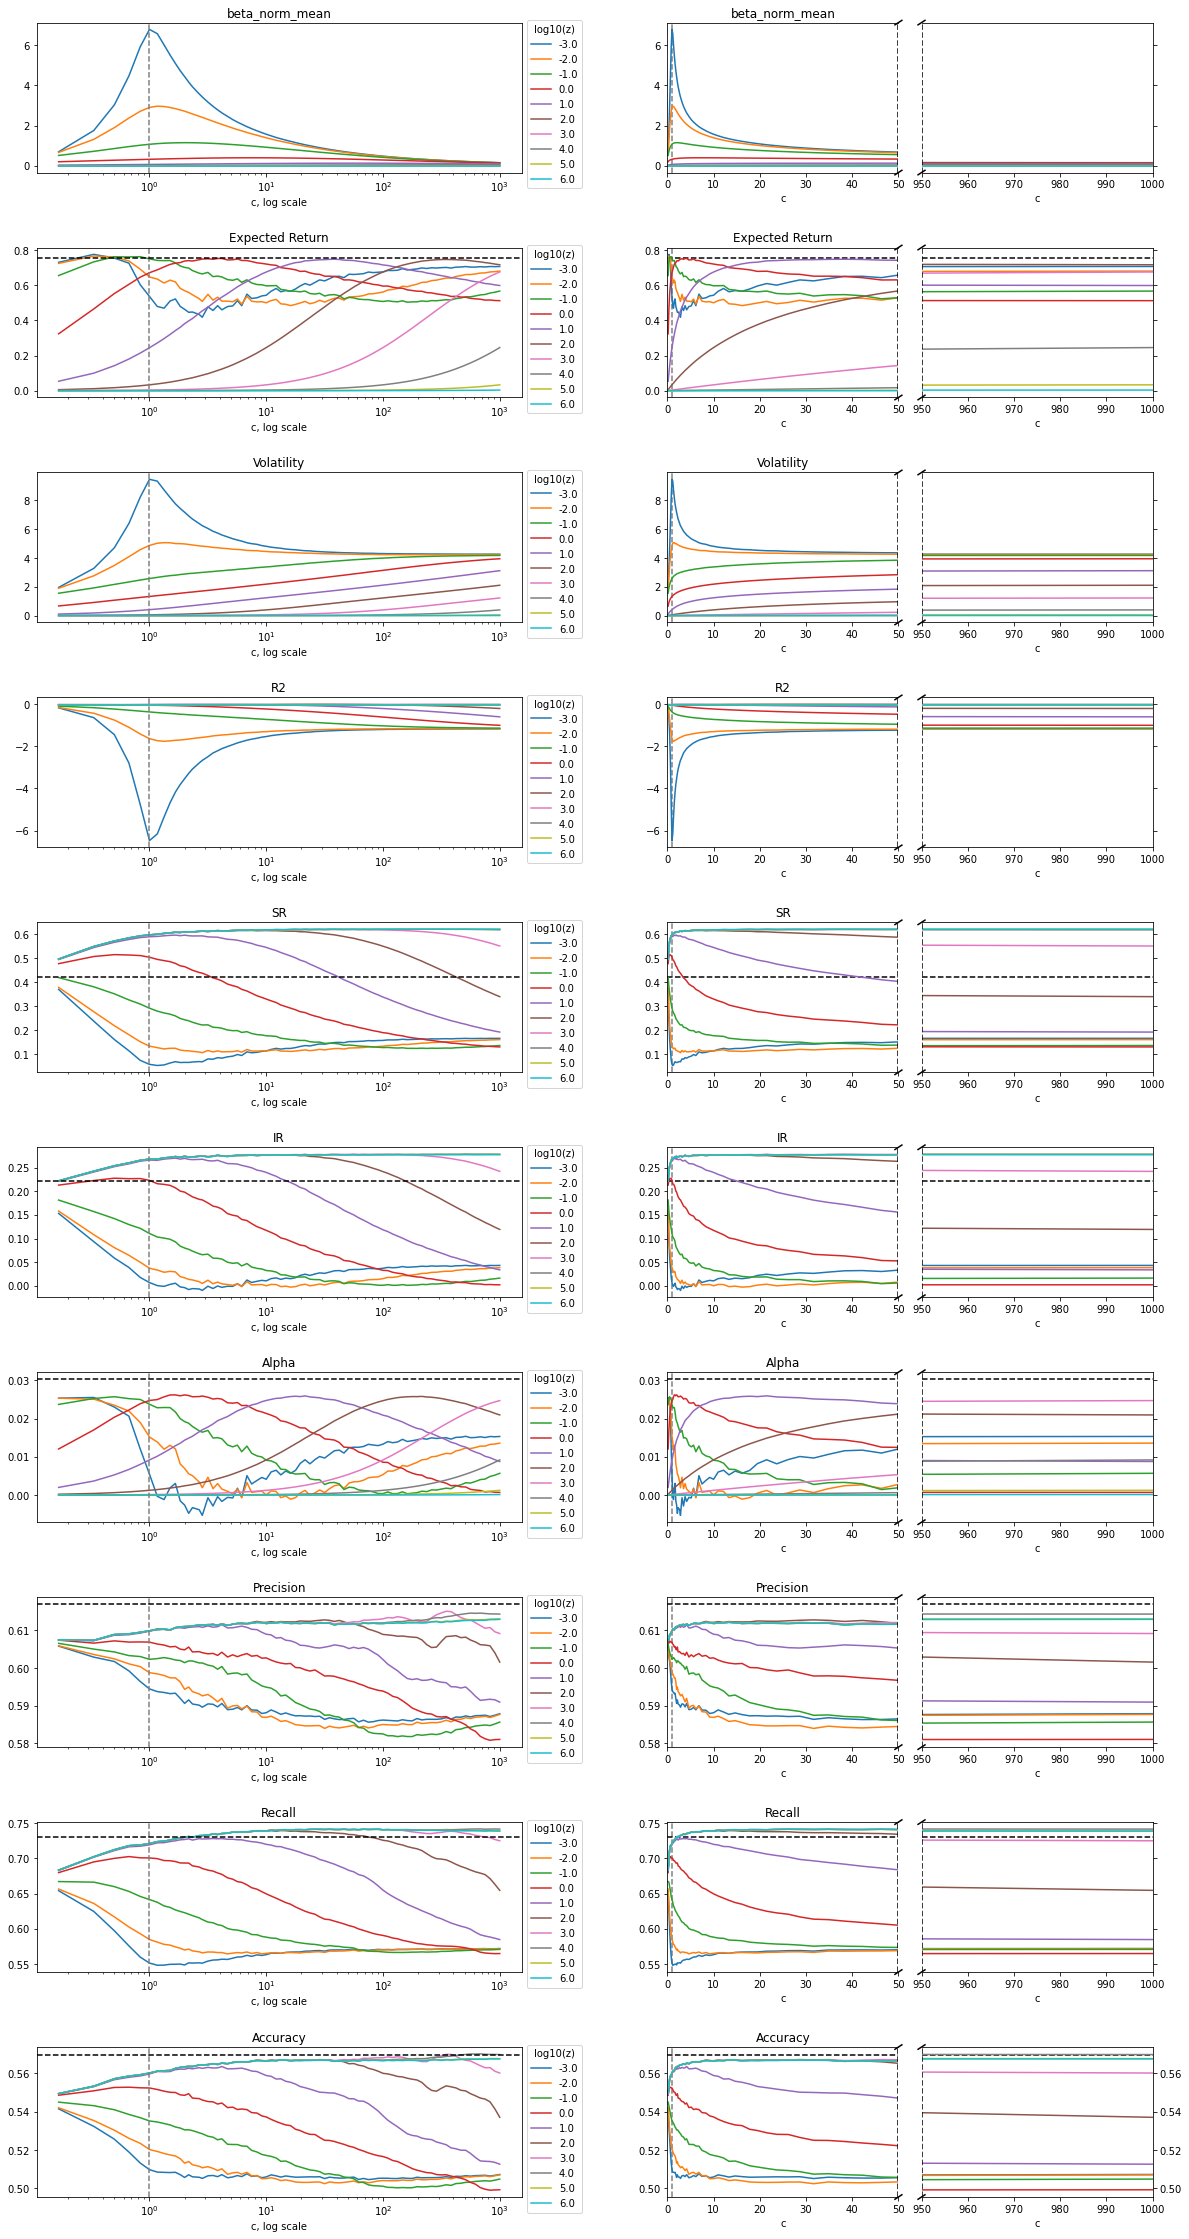

gamma == 2


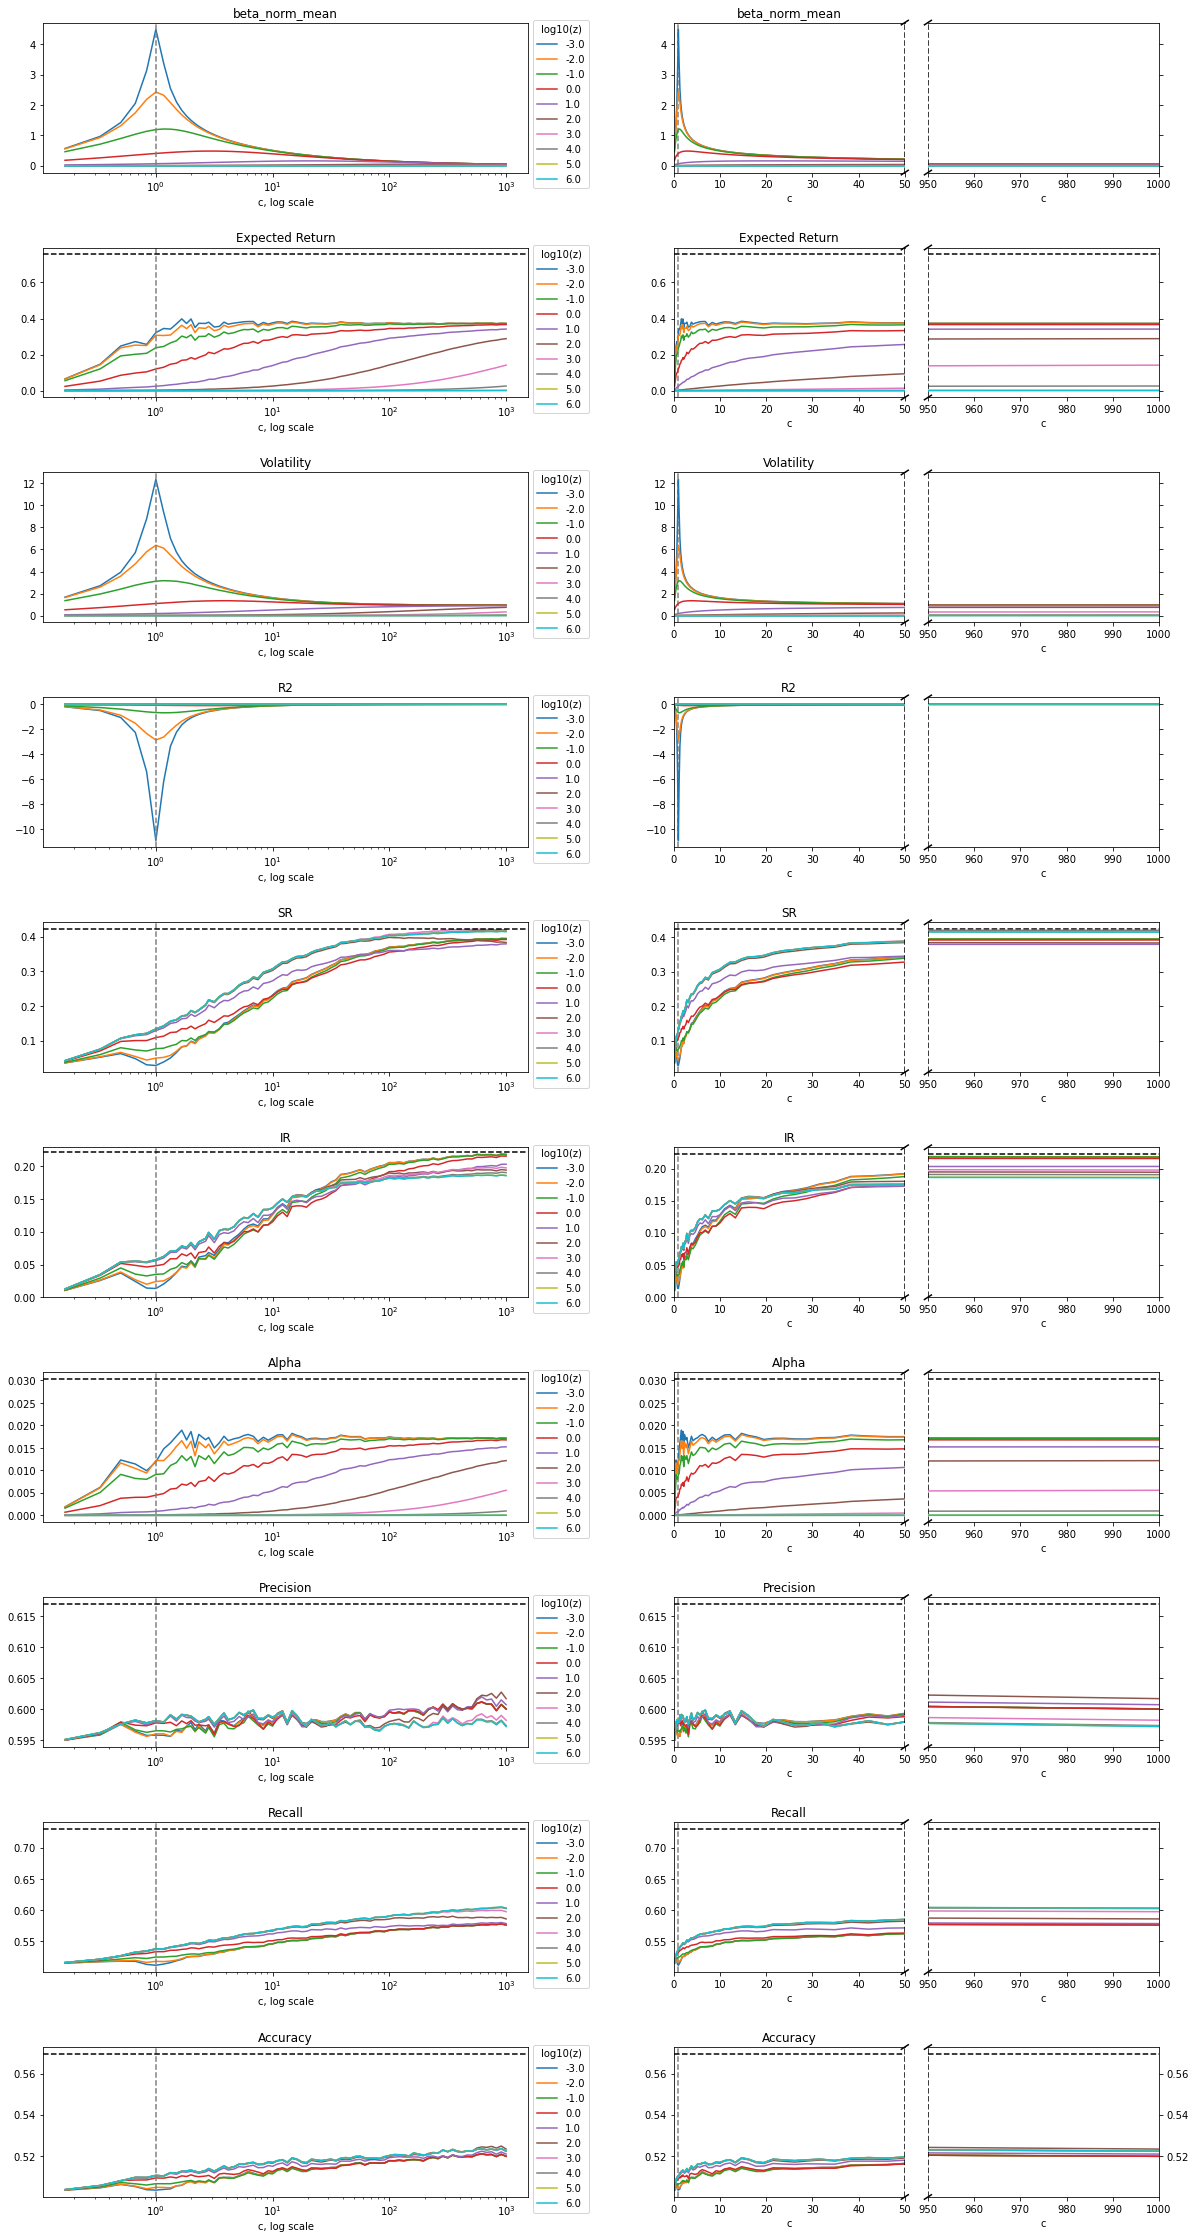

In [8]:
# https://stackoverflow.com/a/34934631/3002299

gamma = 2

for gamma in [0.5, 2]:
    result = metrics_mean[metrics_mean["gamma"]==gamma]

    fig = plt.figure(figsize=(20, 40))
    outer = gridspec.GridSpec(1, 2, wspace=0.3, hspace=0.1)

    plot_cols = ["beta_norm_mean", "Expected Return", "Volatility", "R2", "SR", "IR", "Alpha", "Precision", "Recall", "Accuracy"]
    for i in range(2): # Outer
        inner = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.5)
        if i == 0:
            for j in range(10): # Inner, left column
                col = plot_cols[j]
                ax = plt.Subplot(fig, inner[j])
                result.set_index("c").groupby("log10(z)")[col].plot(ax=ax, title=col)
                ax.axvline(1, c="grey", linestyle="--") # Line vor a complexity of 1, eaning 12 features and 12 data points
                if col in baseline_dict.keys():
                    ax.axhline(baseline_dict[col], c="blacK", linestyle="--") 
                ax.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
                ax.set_xlabel("c, log scale")
                ax.set_xscale('log')
                fig.add_subplot(ax)
        else:  
            for j in range(10): # Inner, right column
                col = plot_cols[j]
                # Two plots with a cut axis
                double_inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=inner[j], wspace=0.1, hspace=0.1)
                
                ax1 = plt.Subplot(fig, double_inner[0])
                ax1.axvline(1, c="grey", linestyle="--") # Line vor a complexity of 1, eaning 12 features and 12 data points
                ax2 = plt.Subplot(fig, double_inner[1], sharey = ax1)
                if col in baseline_dict.keys():
                    ax1.axhline(baseline_dict[col], c="blacK", linestyle="--") 
                    ax2.axhline(baseline_dict[col], c="blacK", linestyle="--") 
                result.set_index("c").groupby("log10(z)")[col].plot(ax=ax1, title=col)
                result.set_index("c").groupby("log10(z)")[col].plot(ax=ax2)
                ax1.set_xlim(0, 50)
                ax2.set_xlim(950, 1000)

                ax1.axvline(x=50, linestyle="--", c="black")
                ax2.axvline(x=950, linestyle="--", c="black")

                # hide the spines between ax and ax2
                ax1.spines['right'].set_visible(False)
                ax2.spines['left'].set_visible(False)
                #ax1.yaxis.tick_left()
                #ax1.tick_params(labelright='off')
                ax2.yaxis.tick_right()

                d = .015 # how big to make the diagonal lines in axes coordinates
                # arguments to pass plot, just so we don't keep repeating them
                kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
                ax1.plot((1-d,1+d), (-d,+d), **kwargs)
                ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

                kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
                ax2.plot((-d,+d), (1-d,1+d), **kwargs)
                ax2.plot((-d,+d), (-d,+d), **kwargs)

                fig.add_subplot(ax1)
                fig.add_subplot(ax2)
    plt.savefig(f"plots/metrics_{gamma}.jpg", bbox_inches='tight')
    print(f"gamma == {gamma}")
    plt.show()

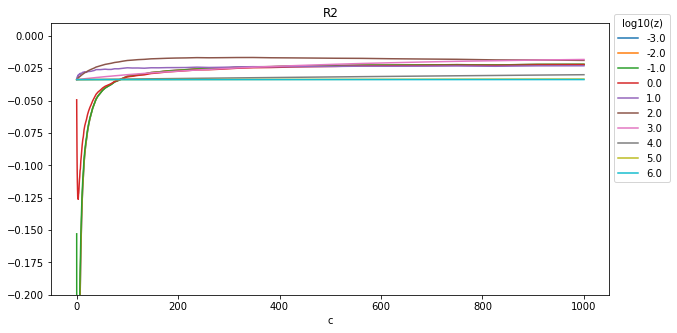

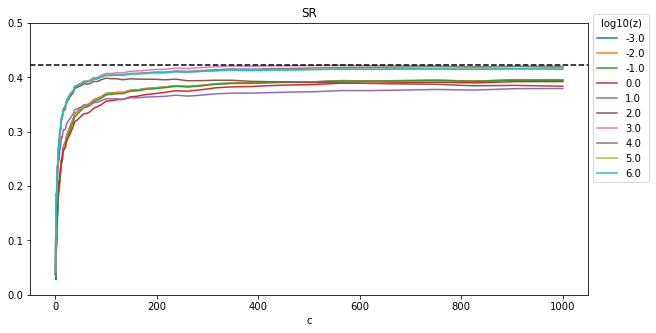

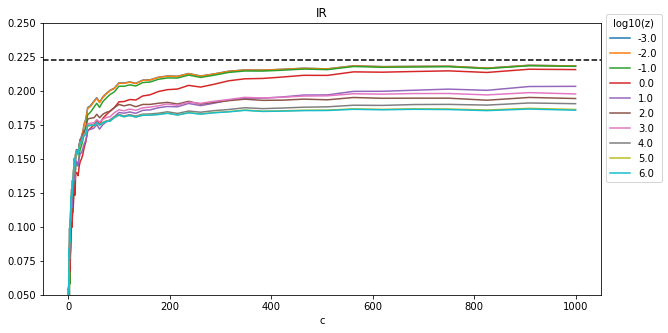

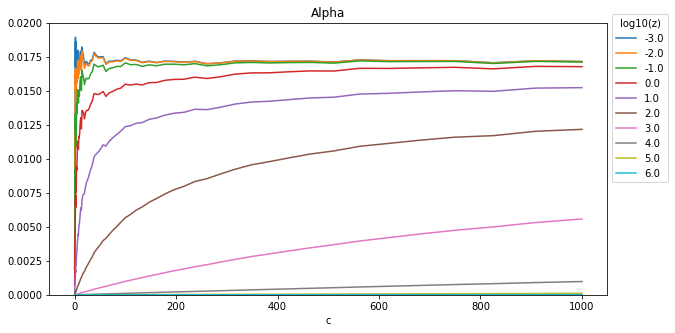

In [9]:
result.set_index("c").groupby("log10(z)")["R2"].plot(ylim=(-0.2,0.01), figsize=(10,5), title="R2")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["SR"].plot(ylim=(0.0, 0.5), figsize=(10,5), title="SR")
plt.gca().axhline(baseline_dict["SR"], c="blacK", linestyle="--") 
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["IR"].plot(ylim=(0.05,0.25), figsize=(10,5), title="IR")
plt.gca().axhline(baseline_dict["IR"], c="blacK", linestyle="--") 
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["Alpha"].plot(ylim=(0.00,0.02), figsize=(10,5), title="Alpha")
plt.gca().axhline(baseline_dict["Alpha"], c="blacK", linestyle="--") 
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

# Gamma

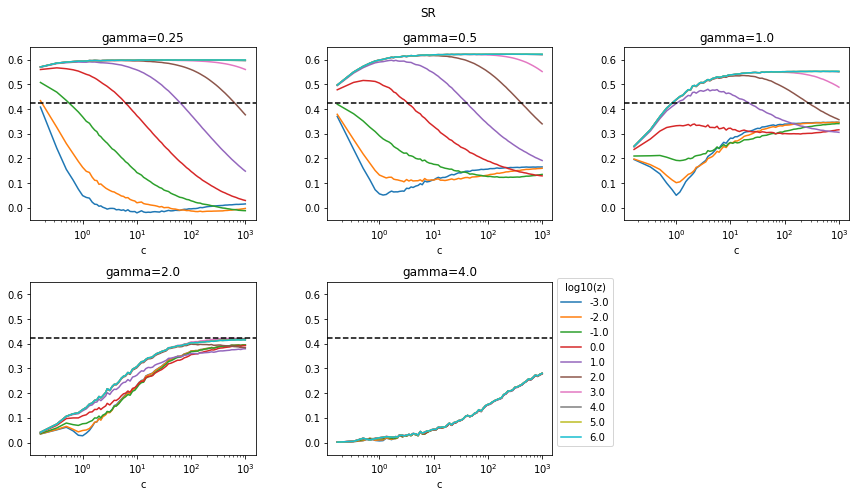

In [10]:
col = "SR"

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
axs = axs.flatten()
for i, gamma in enumerate(metrics_mean["gamma"].unique()):
    metrics_mean[metrics_mean["gamma"]==gamma].set_index("c").groupby("log10(z)")[col].plot(ax=axs[i], title=f"gamma={gamma}")
    axs[i].set_xscale('log')
    axs[i].set_ylim(-0.05, 0.65)
    if col in baseline_dict.keys():
        axs[i].axhline(baseline_dict[col], c="blacK", linestyle="--") 
axs[4].legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
fig.delaxes(axs[5])
fig.suptitle(col)
plt.tight_layout()
plt.savefig(f"plots/gamma_{col}.jpg")
plt.show()

# Market Timing positions vs NBER Recessions

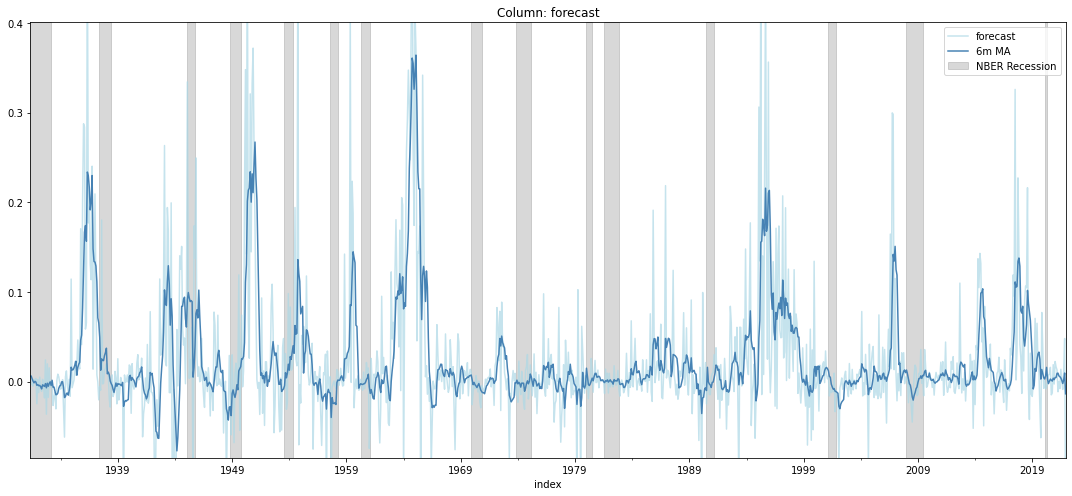

In [13]:
col ="forecast"

# Create RFF model and use it to predict returns
rff_data = RFF(n=6000, gamma=2).features(data)
backtest = Backtest(z=1000, T=12).predict(X=rff_data, y=returns.shift(-1))
backtest = backtest.backtest

# Prepare data for plotting
plot_data = pd.DataFrame()
plot_data[col] = backtest[col]
plot_data["6m MA"] = plot_data[col].rolling(6).mean()

# Get recessions dates from NBER
recessions = [t for date_list in nber.apply(lambda x: pd.date_range(x["peak"], x["trough"]), axis=1).values for t in date_list]
plot_data["NBER Recession"] = plot_data.index.isin(recessions).astype(int)

plot_data = plot_data.dropna()


# Create plot
fig, ax = plt.subplots(figsize=(15,7))
plot_data[col].plot(ax=ax, alpha=0.7, c="lightblue")
plot_data["6m MA"].plot(ax=ax, c="steelblue")
ax.set_ylim(plot_data["6m MA"].min()*1.1, plot_data["6m MA"].max()*1.1)

# Overlay recession periods
ax.fill_between(plot_data.index, ax.get_ylim()[0], ax.get_ylim()[1], 
                where=plot_data["NBER Recession"] == 1 ,color='grey', alpha=0.3,  label="NBER Recession")

ax.legend(loc="upper right")
ax.set_title(f"Column: {col}")
plt.tight_layout()
plt.savefig(f"plots/result_{col}.jpg")
plt.show()

**Expected plot:**

![Expected plot](plots/expected_result.png "Expected plot")